# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


### Hacemos un análisis de la correlación entre las variables del data frame

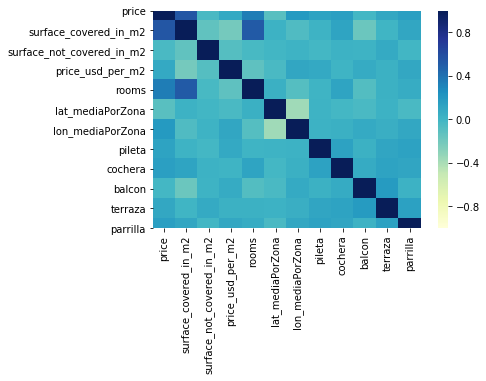

In [10]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu");

# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [11]:
filtroParaElSubsetDeDatos = ["Capital Federal"]

In [12]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28666 entries, 0 to 109291
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              28666 non-null  object 
 1   place_name                 28666 non-null  object 
 2   price                      28666 non-null  float64
 3   surface_covered_in_m2      28666 non-null  float64
 4   surface_not_covered_in_m2  28666 non-null  float64
 5   price_usd_per_m2           28666 non-null  float64
 6   rooms                      28666 non-null  float64
 7   lat_mediaPorZona           28666 non-null  float64
 8   lon_mediaPorZona           28666 non-null  float64
 9   pileta                     28666 non-null  int64  
 10  cochera                    28666 non-null  int64  
 11  balcon                     28666 non-null  int64  
 12  terraza                    28666 non-null  int64  
 13  parrilla              

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

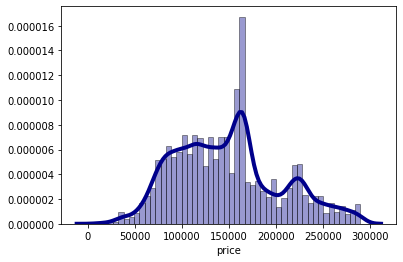

In [13]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


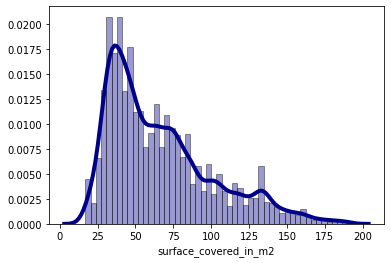

In [14]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

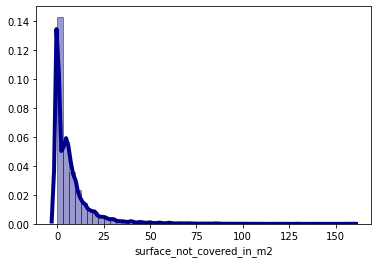

In [15]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

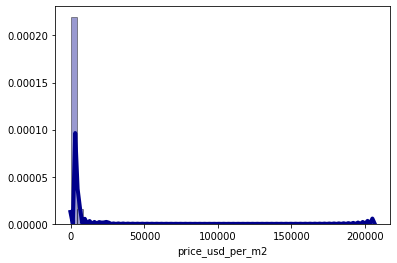

In [16]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

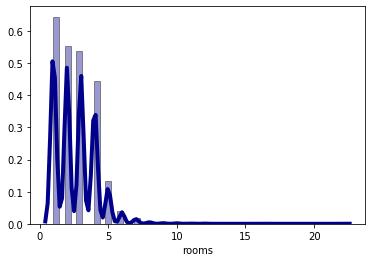

In [17]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [18]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000,28666.000000
mean,148060.307544,66.664330,7.748015,2876.697780,2.635073,-34.602429,-58.435439,0.160748,0.318042,0.349438,0.277960,0.129456
std,55464.870090,34.892107,12.512338,3330.795839,1.448572,0.031108,0.038716,0.367305,0.465724,0.476801,0.448001,0.335710
min,10038.970000,17.000000,0.000000,24.207190,1.000000,-34.860719,-58.524726,0.000000,0.000000,0.000000,0.000000,0.000000
25%,105000.000000,39.000000,0.000000,1811.502616,1.000000,-34.619063,-58.463288,0.000000,0.000000,0.000000,0.000000,0.000000
50%,145000.000000,58.000000,4.000000,2305.555556,2.000000,-34.604566,-58.435071,0.000000,0.000000,0.000000,0.000000,0.000000
75%,178079.347500,85.012457,10.000000,2933.333333,4.000000,-34.582280,-58.399358,0.000000,1.000000,1.000000,1.000000,0.000000
max,290000.000000,190.000000,158.000000,206333.333333,22.000000,-34.549765,-58.354581,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 1000, 5000)

In [20]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 5)

In [21]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24992 entries, 0 to 24991
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              24992 non-null  object 
 1   place_name                 24992 non-null  object 
 2   price                      24992 non-null  float64
 3   surface_covered_in_m2      24992 non-null  float64
 4   surface_not_covered_in_m2  24992 non-null  float64
 5   price_usd_per_m2           24992 non-null  float64
 6   rooms                      24992 non-null  float64
 7   lat_mediaPorZona           24992 non-null  float64
 8   lon_mediaPorZona           24992 non-null  float64
 9   pileta                     24992 non-null  int64  
 10  cochera                    24992 non-null  int64  
 11  balcon                     24992 non-null  int64  
 12  terraza                    24992 non-null  int64  
 13  parrilla                   24992 non-null  int

### Vemos como quedaron los datos

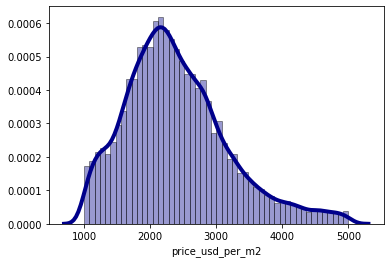

In [22]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

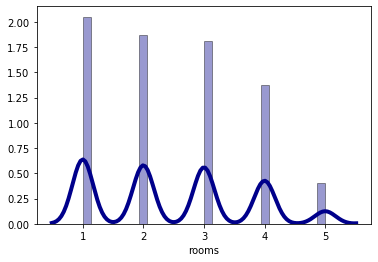

In [23]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

# Analizamos las variables categóricas

palermo                2391
belgrano               2350
recoleta               2119
caballito              1973
villa urquiza          1300
flores                 1173
villa crespo           1119
balvanera              1084
almagro                 941
san telmo               896
capital federal         655
nuñez                   628
saavedra                462
san nicolás             437
villa del parque        419
palermo hollywood       418
floresta                415
boedo                   402
monserrat               385
villa luro              374
villa devoto            362
san cristobal           361
liniers                 345
barracas                343
mataderos               314
colegiales              312
palermo soho            283
parque patricios        281
puerto madero           243
coghlan                 219
chacarita               201
retiro                  200
constitución            177
palermo chico           152
villa pueyrredón        152
paternal            

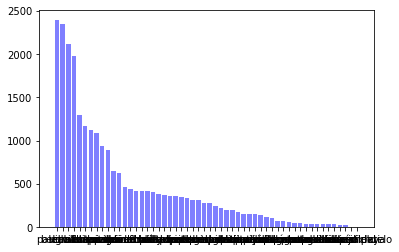

apartment    21340
PH            1440
house         1267
store          945
Name: property_type, dtype: int64


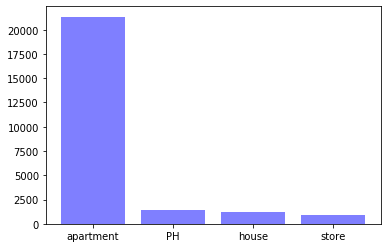

In [24]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [25]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [26]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,PH,mataderos,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,0,0,0
1,apartment,mataderos,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,1,0,0
2,PH,liniers,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,...,0,0,0,0,0,0,0,0,0,0
3,apartment,belgrano,138000.0,40.000000,5.0,3066.666667,1.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0
4,apartment,belgrano,195000.0,60.000000,5.0,3000.000000,2.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [27]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_almagro,place_name_balvanera,place_name_barracas,place_name_belgrano,place_name_boca,place_name_boedo,place_name_caballito,place_name_capital federal,place_name_chacarita,...,place_name_villa general mitre,place_name_villa lugano,place_name_villa luro,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza
0,mataderos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,liniers,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,belgrano,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,palermo soho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,palermo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,flores,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,boedo,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,balvanera,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,caballito,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
20,nuñez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [28]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,PH,0,0,0
1,apartment,1,0,0
14,house,0,1,0
33,store,0,0,1


# Generamos el objeto para el K Fold

In [29]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [30]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,40.000000,15.000000,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55.000000,0.000000,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,92.565511,0.000000,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40.000000,5.000000,3066.666667,1.0,-34.563566,-58.453991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,60.000000,5.000000,3000.000000,2.0,-34.563566,-58.453991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,72.000000,11.578606,1435.774125,4.0,-34.628893,-58.463793,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24988,33.000000,5.753628,1922.400644,1.0,-34.618744,-58.442855,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24989,65.000000,26.000000,1813.186813,4.0,-34.592516,-58.397354,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
24990,39.000000,5.000000,3750.000000,1.0,-34.592516,-58.397354,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Análisis de correlación entre los datos

In [31]:
Desafio_2_aux.showCorrelatedData(df_model_columns, -0.5, 0.5)

surface_covered_in_m2           surface_covered_in_m2             1.00000
                                rooms                             0.65136
surface_not_covered_in_m2       surface_not_covered_in_m2         1.00000
price_usd_per_m2                price_usd_per_m2                  1.00000
rooms                           surface_covered_in_m2             0.65136
                                rooms                             1.00000
lat_mediaPorZona                lat_mediaPorZona                  1.00000
lon_mediaPorZona                lon_mediaPorZona                  1.00000
pileta                          pileta                            1.00000
cochera                         cochera                           1.00000
balcon                          balcon                            1.00000
terraza                         terraza                           1.00000
parrilla                        parrilla                          1.00000
place_name_almagro              place_

En el modelo se detectan las siguientes correlaciones:

surface_covered_in_m2---rooms                             
property_type_apartment---property_type_house

In [32]:
#eliminamos una de las columnas de los pares de correlacion
df_model_columns_no_corr = df_model_columns.drop(labels=['rooms','property_type_house'], axis=1)

# Generamos un modelo con Regresion Lineal

In [33]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [34]:
#seleccionamos un tamaño para el set de test del 10% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [35]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [0.36737322 0.35114743 0.36735758 0.34443542 0.36603951]



Intercept: 
2367.261756511406



Coeficientes: 
[-1.50969265e+02 -1.22412367e+02  4.41625178e+01 -1.44886404e+14
  2.04864232e+14  1.14943532e+02  7.51458999e+01  1.34794777e+01
  8.00815076e-01 -1.44274121e+01 -7.96200439e+13 -1.12844156e+14
 -9.49325438e+13 -8.34345902e+12 -6.57264588e+13 -6.56979813e+13
 -9.57204759e+13 -6.35692211e+13 -1.37561603e+13  7.78369679e+12
 -1.28034436e+13 -1.19412073e+14 -6.19355504e+13 -2.34632815e+13
 -9.38159810e+12 -2.02794832e+13 -8.12369303e+13 -1.68399563e+12
 -6.59586435e+13  1.39412283e+13 -8.08279904e+13 -2.60236464e+13
 -2.83705185e+13 -3.32650717e+13 -1.36965847e+13 -1.25258100e+13
 -1.64102659e+13 -3.24978923e+13 -3.09612386e+09 -6.80358493e+13
 -1.25626730e+13 -7.53259138e+13 -1.31414770e+14 -5.15532654e+13
  2.49654028e+13 -7.14453692e+13 -8.10929140e+13 -1.34317905e+14
 -4.75525110e+12  2.48970201e+11 -5.68637284e+13 -7.29568772e+12
  9.97890189

In [36]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
9821,2096.774194,2311.340955,-214.566761
19299,1560.486486,2374.266736,-813.780250
20795,2450.000000,2476.829236,-26.829236
12736,1235.521236,1952.017594,-716.496358
10518,3476.744186,2971.563611,505.180575
...,...,...,...
19248,2913.043478,3097.172986,-184.129508
10583,2128.205128,2509.087049,-380.881921
22745,1043.478261,1442.762830,-399.284569
23300,2300.000000,2374.219861,-74.219861


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [37]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [38]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(0.0001,1,300), cv)

Score Ridge CV: [0.37399226 0.33479523 0.35961594 0.37181562 0.3706881 ]
Alpha Ridge CV: 0.0001
Coeficientes:  [-160.14028334 -124.53986626   49.54317833  111.03816039  141.2247098
  118.85638234   78.78220753   13.43863787    0.31619824  -12.30866172
  -12.57242686  -77.0069262   -33.61289341  141.713672    -55.33048633
  -39.93374532   49.94845889   -1.23330939   -9.77463573    9.76665003
   17.93330675  -23.44582336   -4.05697363   -3.50794911   13.19938489
   25.87426448  -34.30353972    8.30794548   11.33280977   58.05031214
  142.40913902   83.60692474   79.029419     65.25120065   30.05059033
   -2.33855843    3.39644318   -4.37367942   -9.78533522  -37.73525574
   -2.39394732   67.6228495   142.27885751   15.94814619    8.72996077
  -21.80227958  -24.90990155  -46.11709594    0.35393699   12.4092598
   39.90188858   15.73054776   33.98227745   -3.35063681   -7.5262939
   23.21540925    6.27218438   11.09065339    7.78132157    3.37727976
    0.52951706   -8.53028476   48.343652

In [39]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
9821,2096.774194,2314.288744,-217.514551
19299,1560.486486,2360.248464,-799.761977
20795,2450.000000,2502.241495,-52.241495
12736,1235.521236,1927.047821,-691.526585
10518,3476.744186,2972.807646,503.936540
...,...,...,...
1502,2036.385566,2868.076118,-831.690552
21589,2904.761905,2936.525296,-31.763391
10564,1661.258027,2303.284732,-642.026706
8694,1886.792453,1852.496940,34.295513


# Generamos el modelo para Lasso Cross Validation

In [40]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 922210.4346871376, tolerance: 607781.976




Intercept: 



2397.9464656466334



Coeficientes: 



[-1.54667410e+02 -1.23486220e+02  4.45603330e+01  1.53137526e+02
  4.24299336e+00  1.18019661e+02  7.73854376e+01  1.21768519e+01
 -0.00000000e+00 -1.12911943e+01 -0.00000000e+00 -4.64124897e+01
 -9.36127191e-01  1.06401210e+02 -3.07936609e+01 -2.62680964e+01
  4.90722801e+01  1.94185589e+00 -1.57653180e+01 -7.34521315e+00
  7.02983215e+00  1.55341404e+01 -1.56593972e+01 -1.98246188e+01
 -1.25798525e+01  1.48353456e+00 -7.39640068e+00 -2.14800265e+00
  3.16560843e+01  3.06191668e+01  1.44941382e+02  8.68228436e+01
  7.49320348e+01  6.68552664e+01  3.09470922e+01 -4.43315519e+00
  2.65773083e+00 -3.35546990e-01 -1.63521797e+01 -1.93457584e+01
 -9.30627634e+00  9.40739867e+01  1.76059370e+02  3.15073187e+01
 -2.20163374e+01 -2.12579209e+00  4.01584328e-01 -0.00000000e+00
 -4.20918215e+00  5.66214835e-01  3.56029850e+01 -6.07197407e+00
  3.80497720e-01 -6.47273687e+00 -8.71848444e+00  0.00000000e+00
 -1.11307012e-01 -8.44658081e+00

##### Vemos que el modelo lasso seleccionó algunos coeficientes para no ser incluidos en el modelo, aquellos que valen 0

In [41]:
model_lasso.alpha_

1.1767157720808425

In [42]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
9821,2096.774194,2316.661057,-219.886863
19299,1560.486486,2359.638252,-799.151766
20795,2450.000000,2481.247000,-31.247000
12736,1235.521236,1929.053396,-693.532161
10518,3476.744186,2962.200991,514.543195
...,...,...,...
1502,2036.385566,2868.181356,-831.795790
21589,2904.761905,2933.835061,-29.073156
10564,1661.258027,2292.854283,-631.596257
8694,1886.792453,1856.932325,29.860128


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [43]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [0.36737322 0.35114743 0.36735758 0.34443542 0.36603951]
Score Train Ridge:  [0.37399226 0.33479523 0.35961594 0.37181562 0.3706881 ]
Score Train Lasso:  [0.37402765 0.33475465 0.35984634 0.37223202 0.37042737]


### Visualizamos los errores cuadraticos medios

In [44]:
print("Test RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Test RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Test RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Test RMSE Lineal: 637.1291756484012
Test RMSE RidgeCV: 633.4757621415783
Test RMSE Lasso: 633.3400956851902


In [45]:
print ('Test R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Test R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Test R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Test R2 Lineal: 0.35014678537597
Test R2 RidgeCV: 0.3463945217993012
Test R2 Lasso: 0.34667444677600234


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [46]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

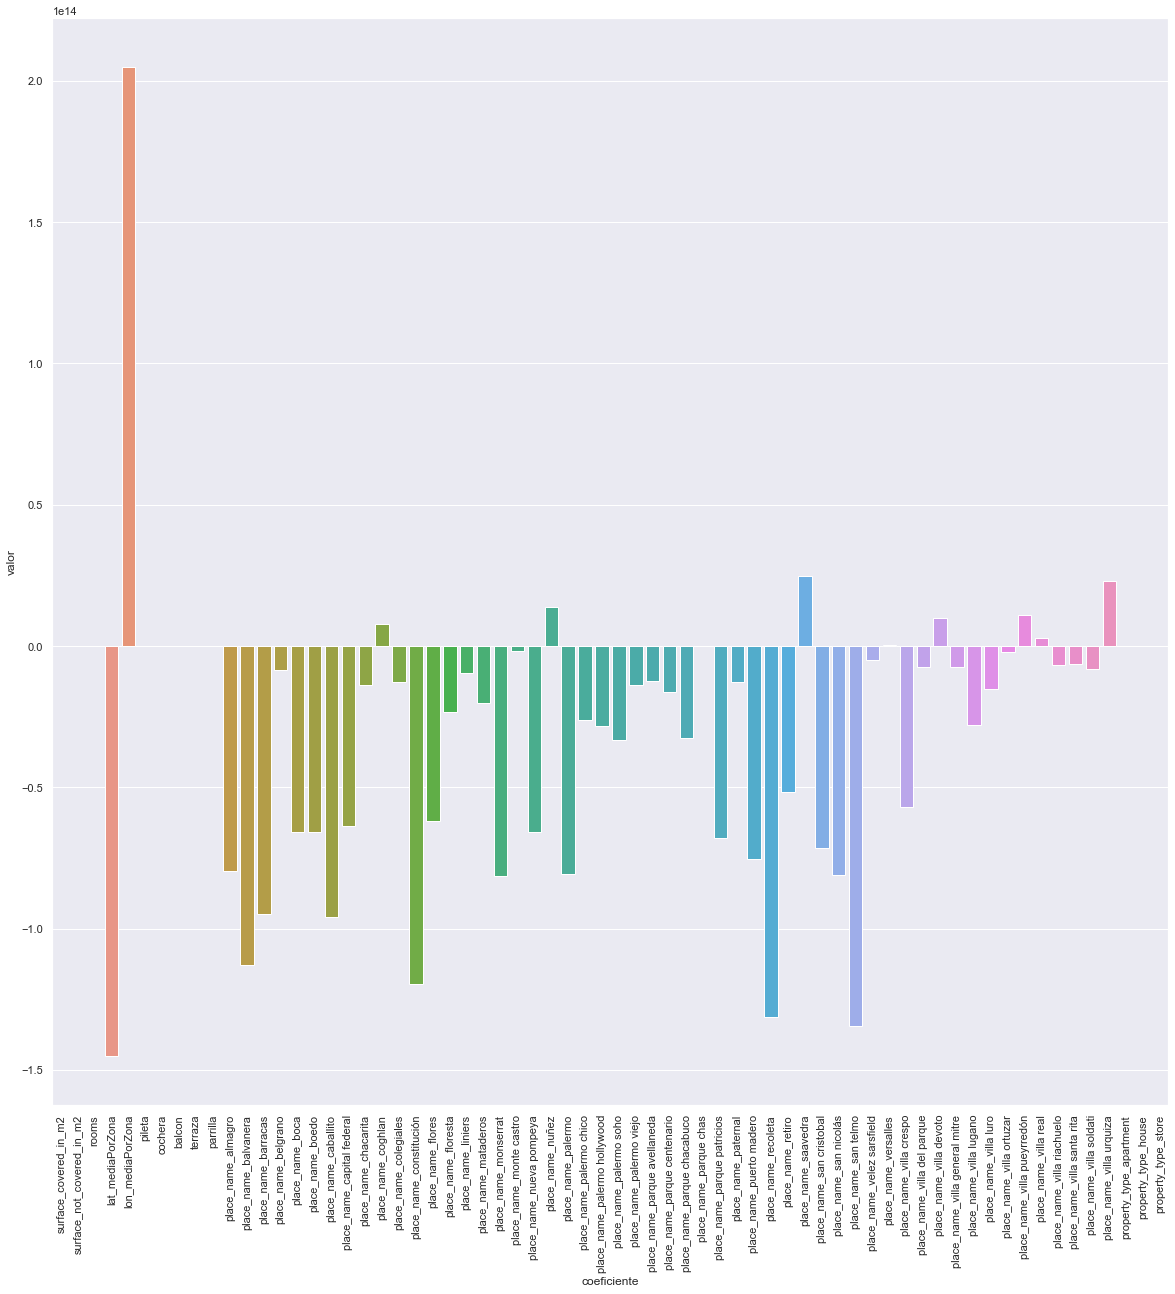

In [47]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [48]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

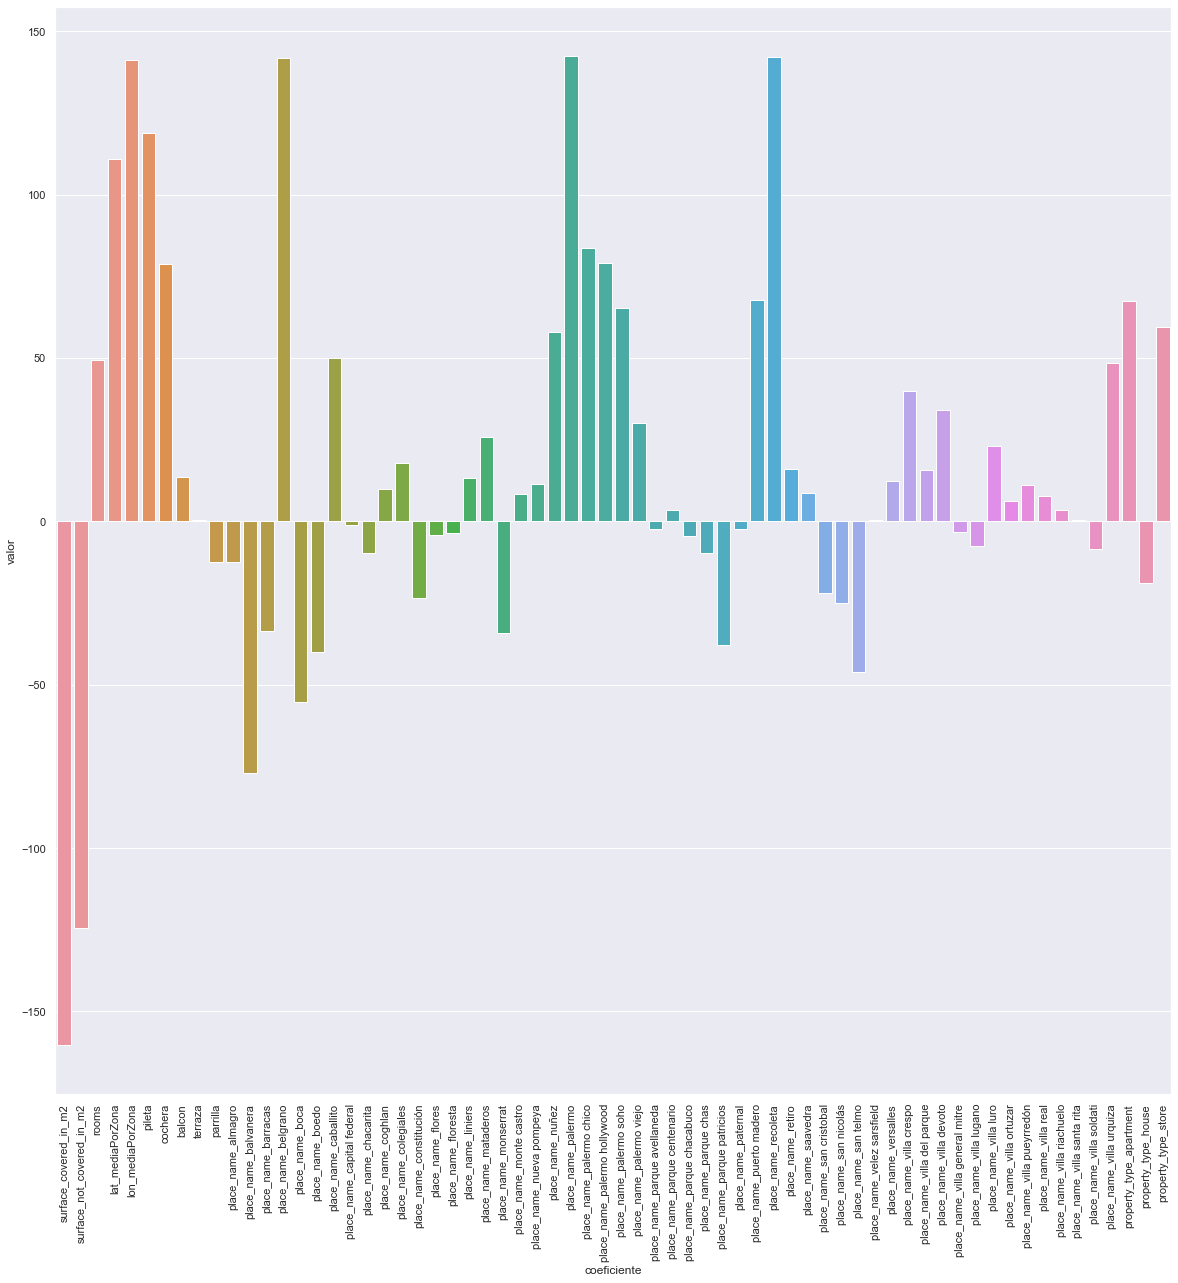

In [49]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [50]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

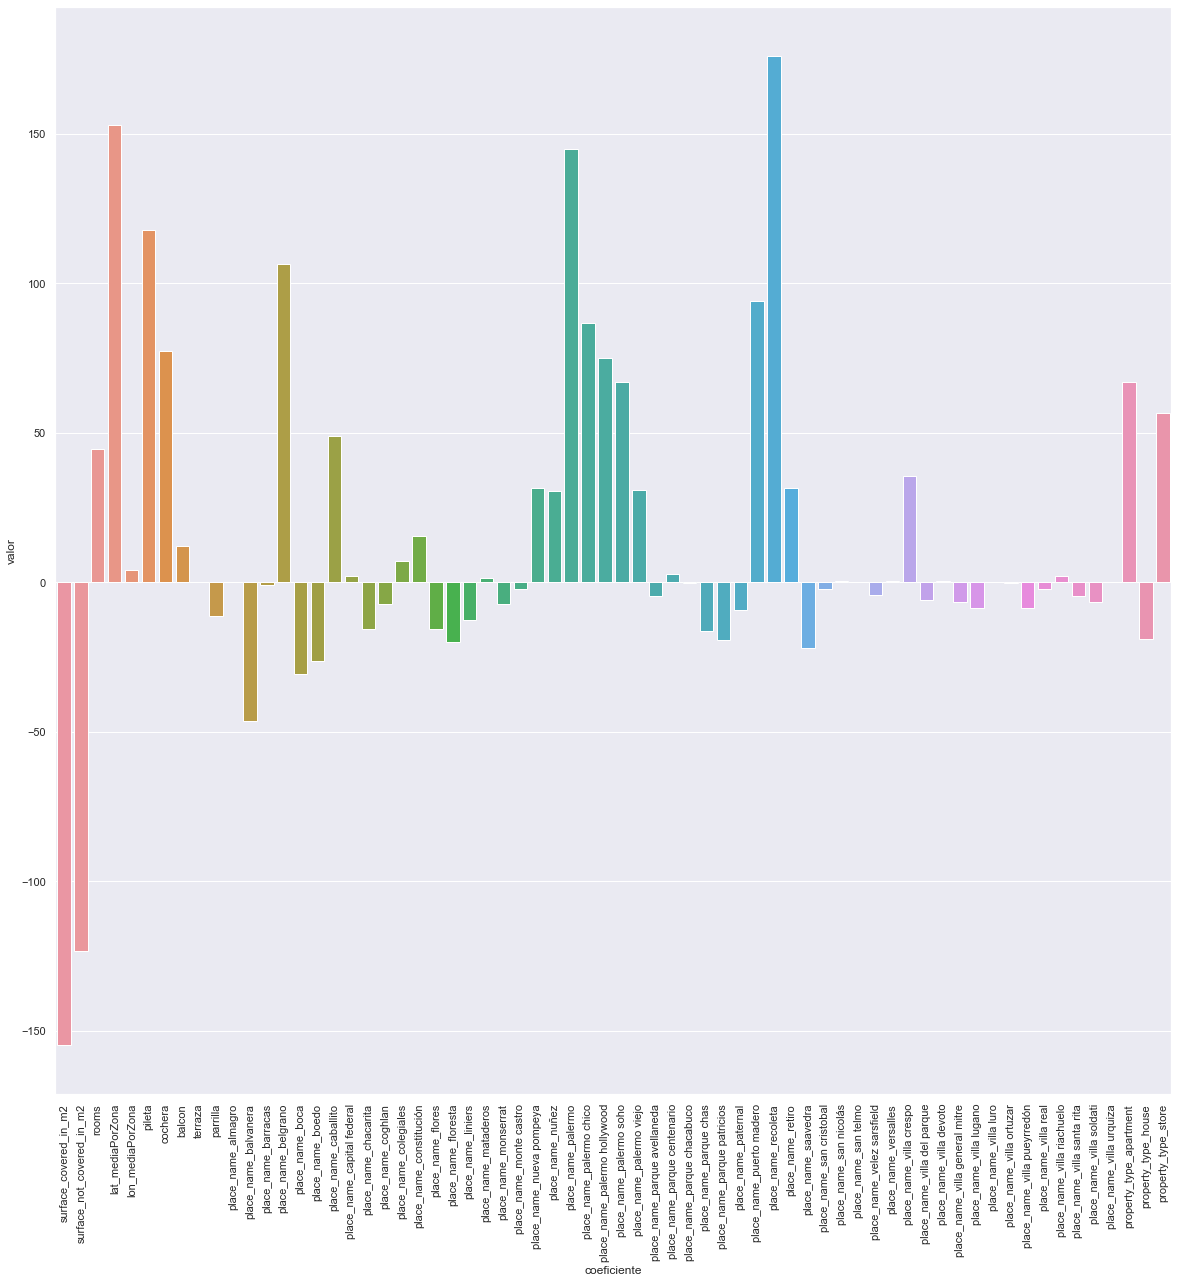

In [51]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# Veamos como quedaron las relaciones entre los resultados predichos VS los resultados esperados

### Regresión Lineal

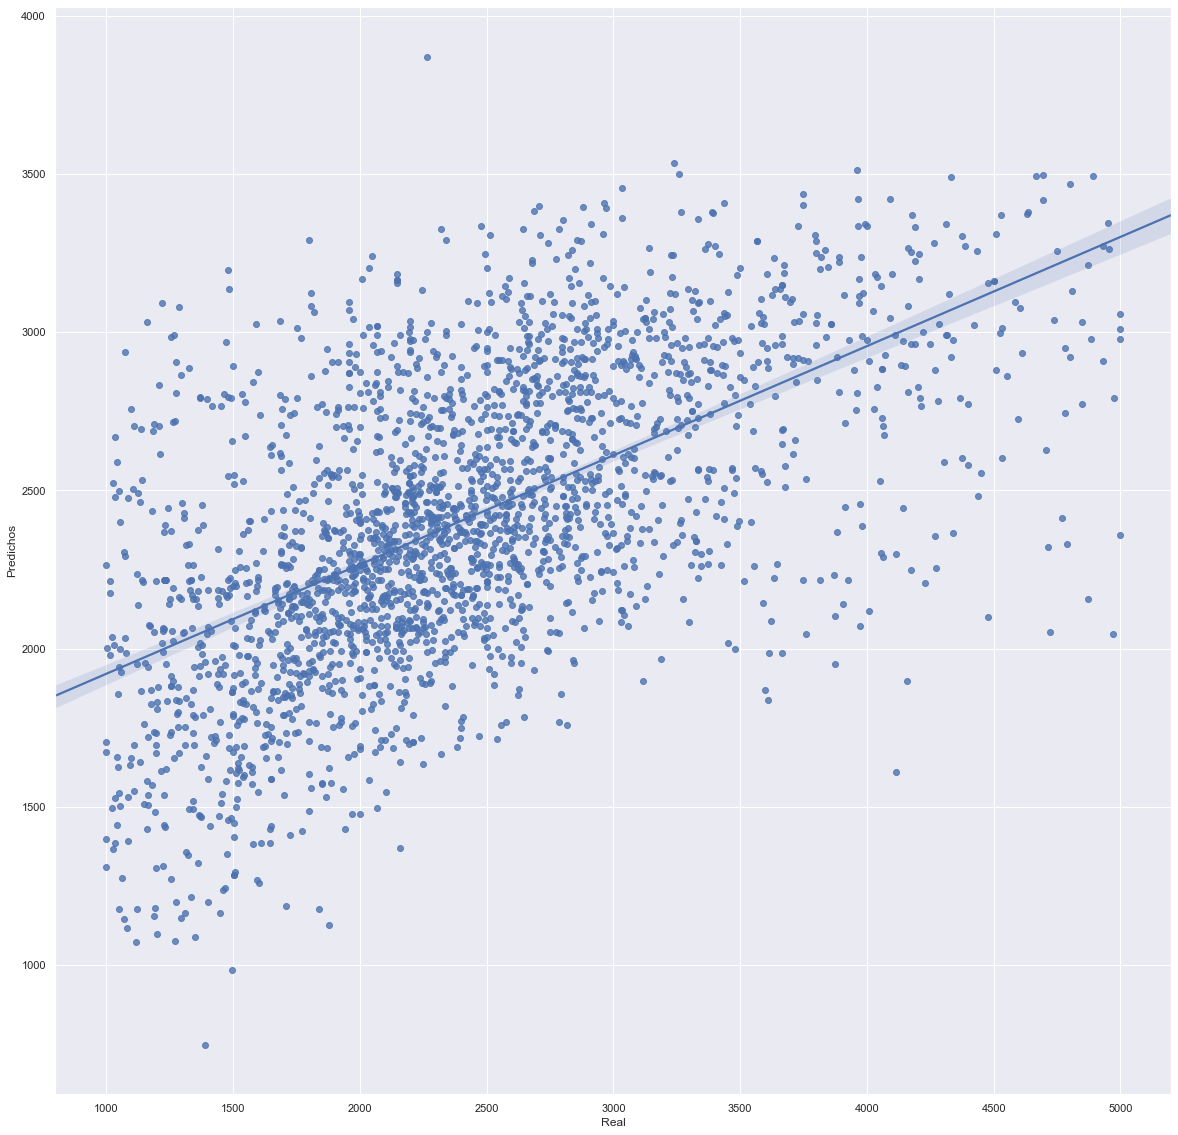

In [52]:
sns.regplot(df_regresion_lineal_prediccion_vs_real['Real'], df_regresion_lineal_prediccion_vs_real['Predichos'])

### RidgeCV

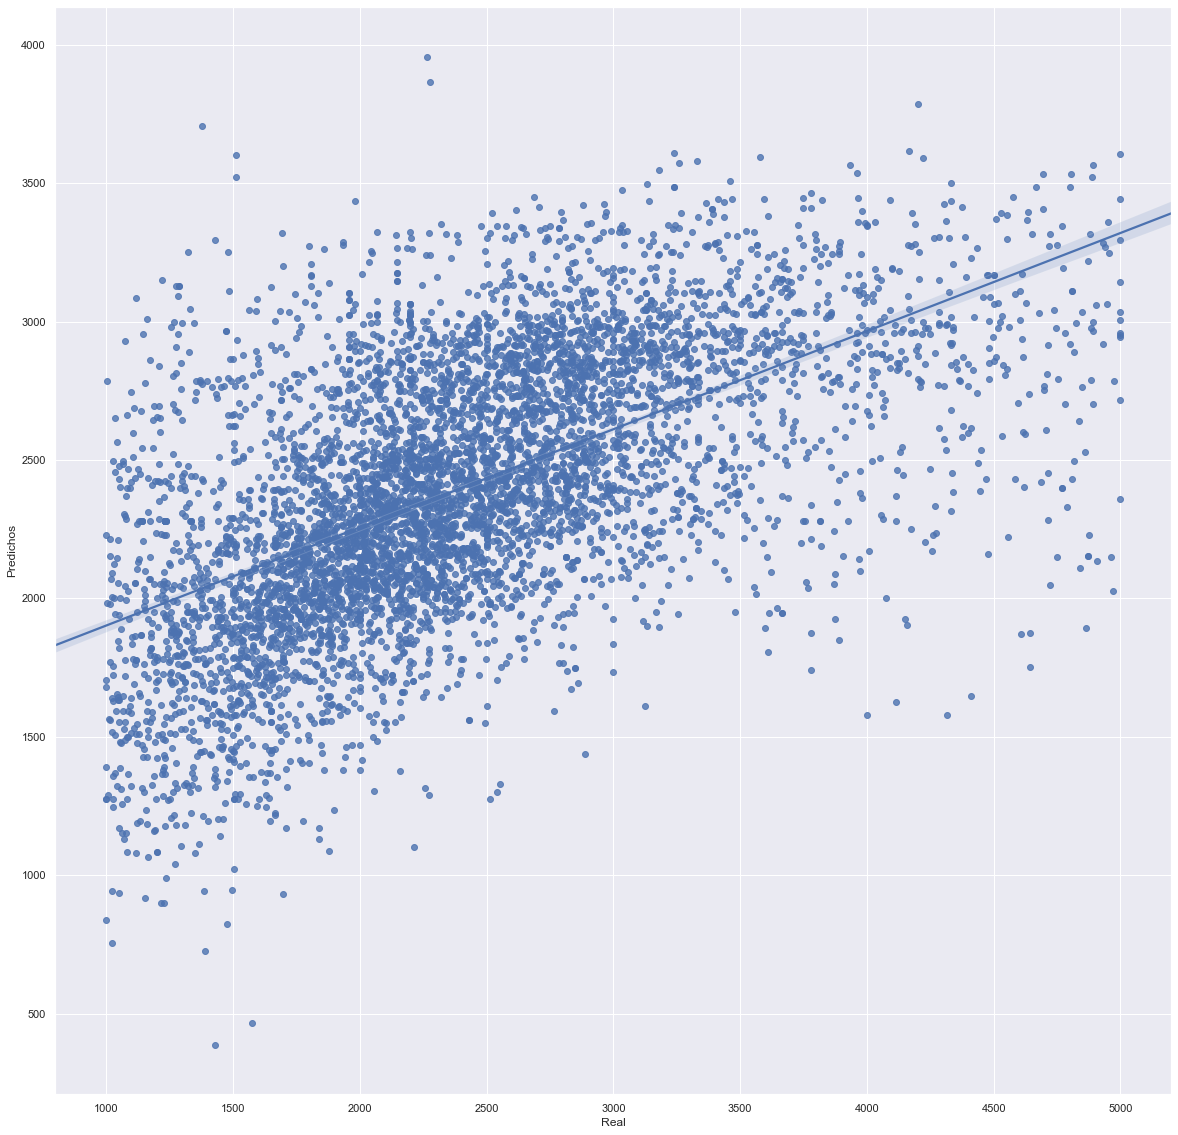

In [53]:
sns.regplot(df_ridge_prediccion_vs_real['Real'], df_ridge_prediccion_vs_real['Predichos'])

### Lasso

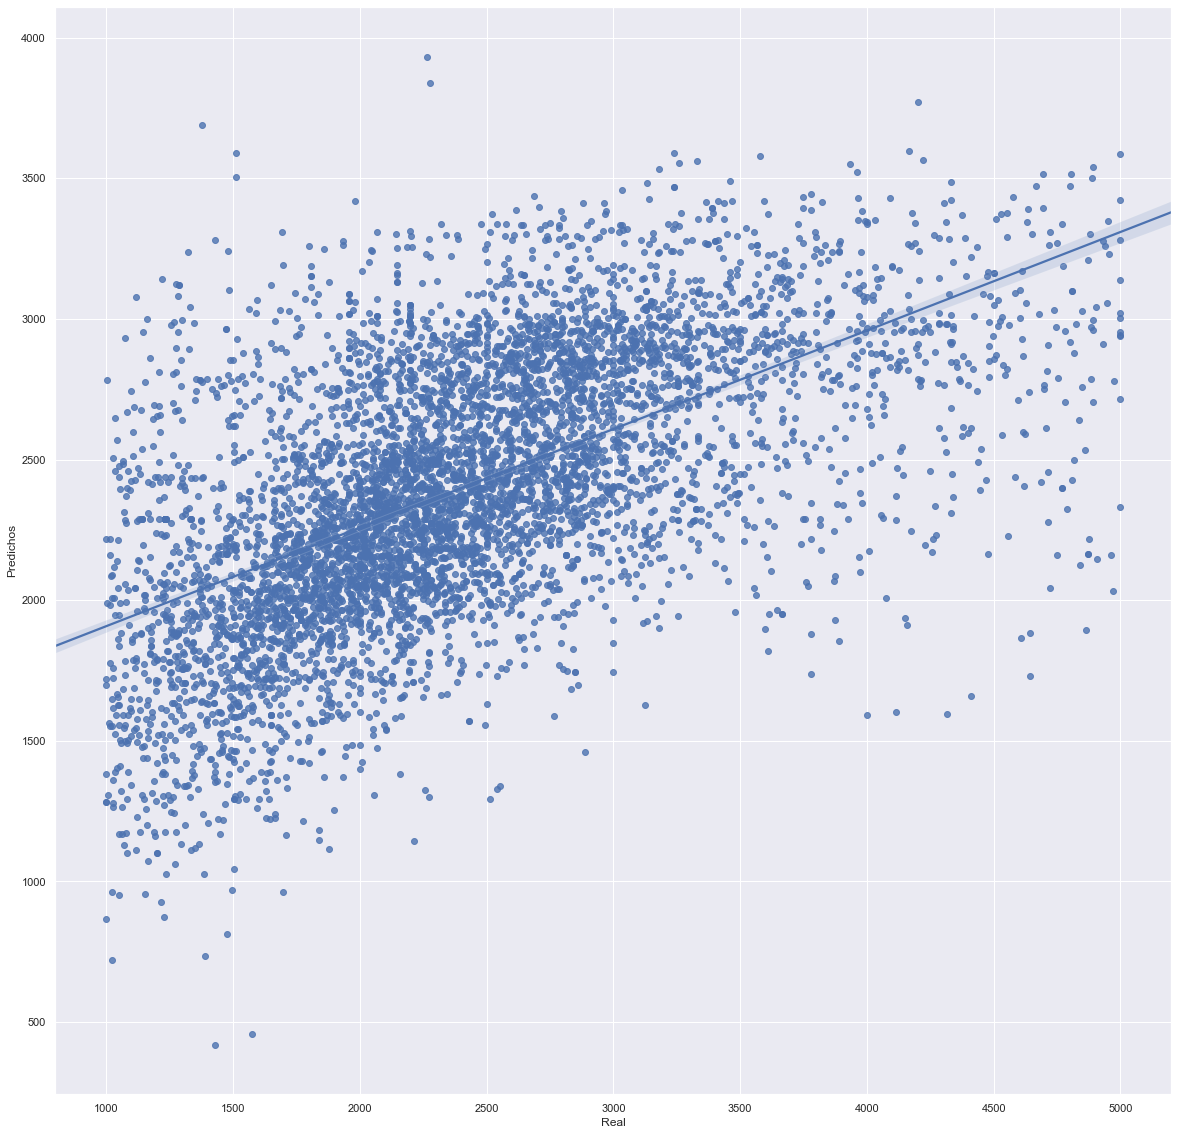

In [54]:
sns.regplot(df_lasso_prediccion_vs_real['Real'], df_lasso_prediccion_vs_real['Predichos'])

# Analisis de oportunidades de compras sobre las propiedades

In [86]:
df_lasso_prediccion_vs_real.sort_index().head(100)

,Real,Predichos,Diferencia
0,1127.272727,1648.278452,-521.005724
7,1707.142857,1166.195507,540.947350
9,2292.372881,2369.889076,-77.516194
16,1705.000000,1831.557829,-126.557829
22,1545.620155,2304.020985,-758.400830
...,...,...,...
380,1750.000000,2100.424444,-350.424444
386,1941.176471,2115.483872,-174.307401
389,1830.952381,2242.936248,-411.983867
390,1884.615385,1998.426161,-113.810777


In [87]:
df_oportunidades_indices = df_lasso_prediccion_vs_real.sort_index().head(100).index

In [88]:
df_oportunidades_indices

Int64Index([  0,   7,   9,  16,  22,  27,  28,  30,  31,  39,  40,  42,  43,
             46,  47,  56,  58,  59,  61,  68,  71,  76,  90, 100, 109, 115,
            116, 117, 119, 127, 133, 137, 139, 140, 141, 143, 145, 149, 150,
            152, 161, 163, 165, 166, 168, 169, 172, 173, 177, 180, 181, 186,
            188, 189, 190, 191, 200, 204, 207, 209, 210, 211, 217, 222, 227,
            231, 239, 245, 246, 248, 250, 254, 255, 256, 259, 264, 267, 268,
            278, 290, 294, 308, 317, 322, 323, 325, 331, 334, 338, 353, 354,
            355, 370, 374, 376, 380, 386, 389, 390, 393],
           dtype='int64')

In [89]:
df_oportunidades = df_subset[df_subset.index.isin(df_oportunidades_indices)]

In [90]:
df_oportunidades

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,PH,mataderos,62000.00,40.00000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,0,0,0
7,PH,mataderos,239000.00,98.00000,42.0,1707.142857,4.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,0,0,0
9,apartment,palermo,270500.00,73.00000,45.0,2292.372881,4.0,-34.582280,-58.425047,0,...,0,0,0,0,0,0,0,1,0,0
16,apartment,caballito,170500.00,46.00000,54.0,1705.000000,2.0,-34.618744,-58.442855,0,...,0,0,0,0,0,0,0,1,0,0
22,apartment,san telmo,79851.93,51.66336,0.0,1545.620155,1.0,-34.620745,-58.376060,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,apartment,flores,63000.00,34.00000,2.0,1750.000000,1.0,-34.628893,-58.463793,0,...,0,0,0,0,0,0,0,1,0,0
386,apartment,flores,66000.00,33.00000,1.0,1941.176471,1.0,-34.628893,-58.463793,0,...,0,0,0,0,0,0,0,1,0,0
389,apartment,almagro,76900.00,42.00000,0.0,1830.952381,1.0,-34.608114,-58.421330,0,...,0,0,0,0,0,0,0,1,0,0
390,apartment,flores,98000.00,50.00000,2.0,1884.615385,1.0,-34.628893,-58.463793,0,...,0,0,0,0,0,0,0,1,0,0


### Seleccionamos 4 casos testigos para analizarlos con nuestro modelo elegido (Lasso)

In [91]:
df_casos_testigos = df_oportunidades.head(4)

In [97]:
df_oportunidades_props = pd.merge(df_casos_testigos, df_lasso_prediccion_vs_real, left_index=True, right_index=True)

In [102]:
df_oportunidades_props[['property_type','place_name','Real','Predichos','Diferencia']]

,property_type,place_name,Real,Predichos,Diferencia
0,PH,mataderos,1127.272727,1648.278452,-521.005724
7,PH,mataderos,1707.142857,1166.195507,540.947350
9,apartment,palermo,2292.372881,2369.889076,-77.516194
16,apartment,caballito,1705.000000,1831.557829,-126.557829


##### De acuerdo al modelo seleccionado, algunas de las propiedades que forman parte del set de datos tienen un valor por m2 inferior al que deberían tener (el valor estimado por el modelo). Esto puede tenerse en cuenta para tomar decisiones, como por ejemplo, evaluar la compra de estas propiedades "subvaluadas" por sus propietarios (pero tasadas más costosas por el modelo), y así sacar beneficios económicos.


Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20